# In class exercises for 11.21.2018 (Filtering)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_sinc_filt as msf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


## Extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [3]:
time = tx[(tx>=0) & (tx<2000)]
print(time.shape)
dataset = data[:,(tx>=0) & (tx<2000)]
print(dataset.shape)
# 960 trials, only take 500 datapoints

(500,)
(960, 500)


## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

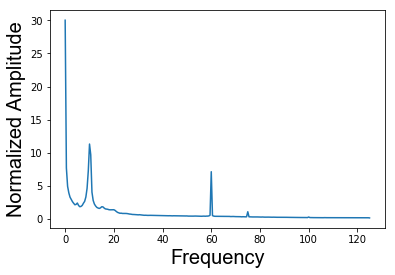

In [4]:
# real fft across trials
sp = np.fft.rfft(dataset, axis=1) 

# normalized amp
amp = np.abs(sp)  
amp = (amp  / time.shape[0] ) * 2 

# average amp across trials
aveamp = np.mean(amp, axis=0)

freq = np.fft.rfftfreq(dataset.shape[1], 1/sr)

plt.plot(freq, aveamp) 
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Normalized Amplitude', **fig_font)
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial

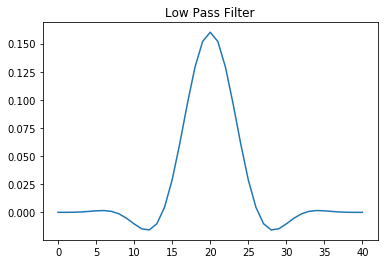

In [21]:
# we imported the filter function at the beginning
# set the arguments, I guess use the usual parameters?
# to make sure it cuts at 20Hz should we calculate fc?
n, sinclp = msf.define_filt(fc=20/sr, b=0.1, window = 'blackman', type_filt = 'lp')

# dataset is 960 trials x 500 time points
# need to apply filter to each trial, then FFT, then plot the average
# loop over each row (each trial)
lpdataset = np.zeros((dataset.shape[0],dataset.shape[1]))
for i in np.arange(dataset.shape[0]):
    lpdataset[i,:] = msf.apply_filt(input_sig=dataset[i,:], input_filter=sinclp)

## Then FFT it again to see if you got rid of the hf components of the signal

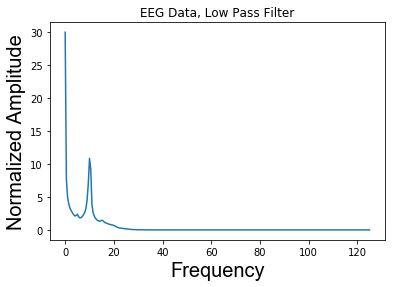

In [22]:
sp = np.fft.rfft(lpdataset, axis=1) 
amp = np.abs(sp)  
amp = (amp  / time.shape[0] ) * 2 

aveamp = np.mean(amp, axis=0)

freq = np.fft.rfftfreq(dataset.shape[1], 1/sr)

plt.plot(freq, aveamp) 
plt.title('EEG Data, Low Pass Filter')
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Normalized Amplitude', **fig_font)
plt.show()

# yup that 60Hz peak is gone!

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter (with an appropriate fc), then make a hp filter (with an appropriate fc)
* use np.convolve to combine the two filters 
* then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

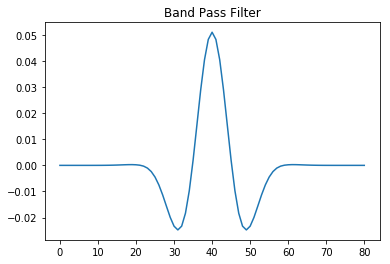

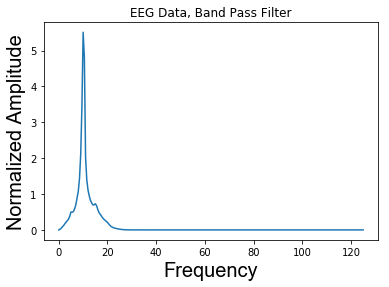

In [26]:
# low pass filter
# if it passes low frequencies, we want it to get rid of everything above 14Hz
n, sinclp = msf.define_filt(fc=14/sr, b=0.1, window = 'blackman', type_filt = 'lp')

# high pass filter
n, sinchp = msf.define_filt(fc=6/sr, b=0.1, window = 'blackman', type_filt = 'hp')

bandpass = np.convolve(sinclp, sinchp)
# can plot what the filter is doing
plt.plot(bandpass)
plt.title('Band Pass Filter')
plt.show()

# apply the filter to each trial
bpdataset = np.zeros((dataset.shape[0],dataset.shape[1]))
for i in np.arange(dataset.shape[0]):
    bpdataset[i,:] = msf.apply_filt(input_sig=dataset[i,:], input_filter=bandpass)
    
# FFT, average, and plot the filtered data
sp = np.fft.rfft(bpdataset, axis=1) 
amp = np.abs(sp)  
amp = (amp  / time.shape[0] ) * 2 
aveamp = np.mean(amp, axis=0)
freq = np.fft.rfftfreq(dataset.shape[1], 1/sr)

plt.plot(freq, aveamp) 
plt.title('EEG Data, Band Pass Filter')
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Normalized Amplitude', **fig_font)
plt.show()

# so everything except that one peak in our window of interest gets totally wiped out

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

## Then FFT and look at filtered signal in the frequency domain

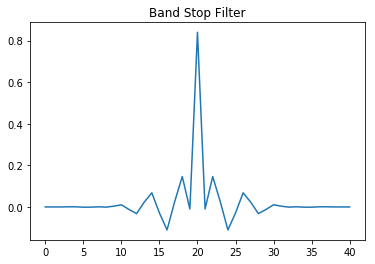

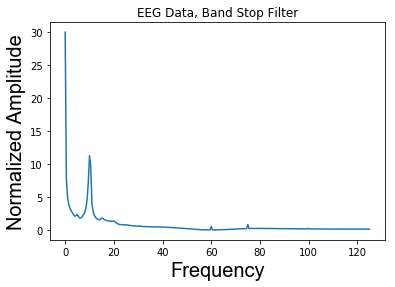

In [27]:
# low pass filter
# if it passes low frequencies, we want it to get rid of everything above 50Hz
n, sinclp = msf.define_filt(fc=50/sr, b=0.1, window = 'blackman', type_filt = 'lp')

# high pass filter
n, sinchp = msf.define_filt(fc=70/sr, b=0.1, window = 'blackman', type_filt = 'hp')

bandstop = sinclp+sinchp
plt.plot(bandstop)
plt.title('Band Stop Filter')
plt.show()

# apply the filter to each trial
bsdataset = np.zeros((dataset.shape[0],dataset.shape[1]))
for i in np.arange(dataset.shape[0]):
    bsdataset[i,:] = msf.apply_filt(input_sig=dataset[i,:], input_filter=bandstop)
    
# FFT, average, and plot the filtered data
sp = np.fft.rfft(bsdataset, axis=1) 
amp = np.abs(sp)  
amp = (amp  / time.shape[0] ) * 2 
aveamp = np.mean(amp, axis=0)
freq = np.fft.rfftfreq(dataset.shape[1], 1/sr)

plt.plot(freq, aveamp) 
plt.title('EEG Data, Band Stop Filter')
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Normalized Amplitude', **fig_font)
plt.show()